## Advanced chunking strategies provided by Amazon Bedrock Knowledge Bases

In this notebook, we will create a knowledge base to provide sample code using haystack for the CUSTOM chunking option supported by Amazon Bedrock Knowledge Bases. 

Chunking breaks down the text into smaller segments before embedding. The chunking strategy can't be modified after you create the data source.
As of now, Amazon Bedrock Knowledge Bases only support a few built-in chunking options: no chunking, fixed sized chunking, and default chunking. 

* With custom chunking, customers can have more control over how their data is processed and chunked using Lambda function.


We will use a synthetic 10K report as data for a fiticious company called `Octank Financial` to demo the solution.
After creating knowledge bases we will evaluate the results on the same dataset. The focus will be on improving the quality of search results which in turn will improve the accuracy of responses generated by the foundation model. 

## 1. Import the needed libraries
First step is to install the pre-requisites packages.

In [ ]:
%pip install --upgrade pip --quiet
%pip install -r ../requirements.txt --no-deps --quiet
%pip install -r ../requirements.txt --upgrade --quiet

In [ ]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [ ]:
import botocore
botocore.__version__

In [ ]:
import os
import sys
import time
import boto3
import logging
import pprint
import json

# Set the path to import module
from pathlib import Path
current_path = Path().resolve()
current_path = current_path.parent
if str(current_path) not in sys.path:
    sys.path.append(str(current_path))
# Print sys.path to verify
# print(sys.path)

from utils.knowledge_base import BedrockKnowledgeBase

In [ ]:
#Clients
s3_client = boto3.client('s3')
sts_client = boto3.client('sts')
session = boto3.session.Session()
region =  session.region_name
account_id = sts_client.get_caller_identity()["Account"]
bedrock_agent_client = boto3.client('bedrock-agent')
bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime') 
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
region, account_id

In [ ]:
import time

# Get the current timestamp
current_time = time.time()

# Format the timestamp as a string
timestamp_str = time.strftime("%Y%m%d%H%M%S", time.localtime(current_time))[-7:]
# Create the suffix using the timestamp
suffix = f"{timestamp_str}"

knowledge_base_name_custom = 'custom-chunking-kb'
knowledge_base_description = "Knowledge Base containing complex PDF."
bucket_name = f'{knowledge_base_name_custom}-{suffix}'
intermediate_bucket_name = f'{knowledge_base_name_custom}-intermediate-{suffix}'
lambda_function_name = f'{knowledge_base_name_custom}-lambda-{suffix}'
foundation_model = "anthropic.claude-3-sonnet-20240229-v1:0"

# Define data sources
data_source=[{"type": "S3", "bucket_name": bucket_name}]

# 2. Visualizing our simple Haystack Pipeline

Haystack gives us many options in the way we clean and split our data. For this simple pipeline, we will use yaml to define our chunking logic using the string below.

- Reference: https://docs.haystack.deepset.ai/docs/preprocessors

In [ ]:
pipe_yaml = '''
components:
  cleaner:
    init_parameters:
      remove_empty_lines: true
      remove_extra_whitespaces: false
      remove_regex: null
      remove_repeated_substrings: true
      remove_substrings: null
    type: haystack.components.preprocessors.document_cleaner.DocumentCleaner
  splitter:
    init_parameters:
      split_by: word
      split_length: 350
      split_overlap: 20
    type: haystack.components.preprocessors.document_splitter.DocumentSplitter
connections:
  - receiver: splitter.documents
    sender: cleaner.documents
max_loops_allowed: 100
metadata: {}
'''

Using this code, we load our pipeline from the yaml string above, and visualize how the data will flow through, and what transformations are applied from beginning to end

In [ ]:
from haystack import Pipeline

pipe = Pipeline.loads(pipe_yaml)
pipe.show()

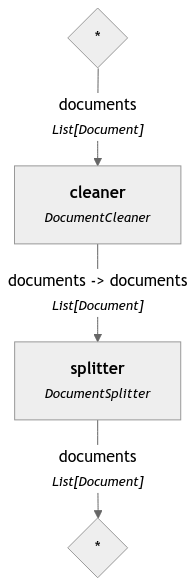

## 3. Create Knowledge Base with custom chunking option using Lambda Functions
When creating an Knowledge Bases (KB) for Amazon Bedrock, you can connect a Lambda function to specify your custom chunking logic. During ingestion, if lambda function is provided, Knowledge Bases, will run the lambda function, and store the input and output values in the intermediate s3 bucket provided.

> <br>
> Note: Lambda function with KB can be used for adding custom chunking logic as well processing your chunks for example, adding chunk level metadata. In this example we are focusing on using haystack within our Lambda function for custom chunking logic.
> <br></br>

### 3.1 Create the Lambda Function

We will now create a lambda function which will have code for custom chunking. To do so we will:

1. Create the `lambda_function.py` file which contains the logic for custom chunking.
2. Create the IAM role for our Lambda function.
3. Create the lambda function with the required permissions.

#### Create the function code
 Let's create the lambda function tha implements the functions for `reading your file from intermediate bucket`, `process the contents with custom chunking logic` and `write the output back to s3 bucket`. 

In [ ]:
%%writefile lambda_function.py
import json
import os
import tempfile
import boto3
import logging
from haystack import Pipeline, Document

pipe_yaml = '''
components:
  cleaner:
    init_parameters:
      remove_empty_lines: true
      remove_extra_whitespaces: false
      remove_regex: null
      remove_repeated_substrings: true
      remove_substrings: null
    type: haystack.components.preprocessors.document_cleaner.DocumentCleaner
  splitter:
    init_parameters:
      split_by: word
      split_length: 350
      split_overlap: 20
    type: haystack.components.preprocessors.document_splitter.DocumentSplitter
connections:
  - receiver: splitter.documents
    sender: cleaner.documents
max_loops_allowed: 100
metadata: {}
'''

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

def load_pipe():
    pipe = Pipeline.loads(pipe_yaml)
    return pipe

def lambda_handler(event, context):
    logger.debug('input={}'.format(json.dumps(event)))
    s3 = boto3.client('s3')

    # Extract relevant information from the input event
    input_files = event.get('inputFiles')
    input_bucket = event.get('bucketName')

    if not all([input_files, input_bucket]):
        raise ValueError("Missing required input parameters")

    output_files = []

    for input_file in input_files:
        content_batches = input_file.get('contentBatches', [])
        file_metadata = input_file.get('fileMetadata', {})
        original_file_location = input_file.get('originalFileLocation', {})

        processed_batches = []

        for batch in content_batches:
            input_key = batch.get('key')

            if not input_key:
                raise ValueError("Missing key in content batch")

            file_content = read_s3_file(s3, input_bucket, input_key)
            
            document = Document(content=str(file_content), meta=file_metadata)

            # Process content using Haystack pipeline
            processed_content = process_content([document])

            output_key = f"Output/{input_key}"

            # Write processed content back to S3
            write_to_s3(s3, input_bucket, output_key, processed_content)

            # Add processed batch information
            processed_batches.append({
                'key': output_key
            })

        # Prepare output file information
        output_file = {
            'originalFileLocation': original_file_location,
            'fileMetadata': file_metadata,
            'contentBatches': processed_batches
        }
        output_files.append(output_file)

    result = {'outputFiles': output_files}

    return result

def read_s3_file(s3_client, bucket, key):
    response = s3_client.get_object(Bucket=bucket, Key=key)
    return json.loads(response['Body'].read().decode('utf-8'))

def write_to_s3(s3_client, bucket, key, content):
    s3_client.put_object(Bucket=bucket, Key=key, Body=json.dumps(content))

def process_content(file_path):
    # Run the pipeline on the file
    pipe = load_pipe()
    logger.debug(f'file input: {file_path}')
    result = pipe.run({'cleaner': {"documents": file_path}})
    # Process the result into the expected output format
    processed_content = {
        'fileContents': []
    }

    for doc in result['splitter']['documents']:
        processed_content['fileContents'].append({
            'contentType': 'text',  # Adjust as needed
            'contentMetadata': doc.meta,  # Add metadata if available
            'contentBody': doc.content
        })

    return processed_content


The standard chunking strategies values provided by knowledge bases are following: 

**Parameter values:**
 
```
"chunkingStrategy": "FIXED_SIZE | NONE | HIERARCHICAL | SEMANTIC"
```

For implementing our custom logic, we have included an option in the `knowledge_base.py` class for passing a value of `CUSTOM"`. 
If you pass the chunking strategy as `CUSTOM` in this class, it will do the following: 

1. It select the `chunkingStrategy` as `NONE`. 
2. It will add `customTransformationConfiguration` to the `vectorIngestionConfiguration` as follows: 

```
{
...
   "vectorIngestionConfiguration": {
    "customTransformationConfiguration": { 
         "intermediateStorage": { 
            "s3Location": { 
               "uri": "string"
            }
         },
         "transformations": [
            {
               "transformationFunction": {
                  "lambdaConfiguration": {
                     "lambdaArn": "string"
                  }
               },
               "stepToApply": "string" // enum of POST_CHUNKING
            }
         ]
      },
      "chunkingConfiguration": {
         "chunkingStrategy": "NONE"
         ...
   }
}

```


In [ ]:
knowledge_base_custom = BedrockKnowledgeBase(
    kb_name=f'{knowledge_base_name_custom}-{suffix}',
    kb_description=knowledge_base_description,
    data_sources=data_source,
    lambda_function_name=lambda_function_name,
    intermediate_bucket_name=intermediate_bucket_name, 
    chunking_strategy = "CUSTOM", 
    suffix = f'{suffix}-c'
)

## IMPORTANT! 
Once your lambda function is created, you must add and environment variable like so: 

`HAYSTACK_TELEMETRY_ENABLED = False`

Lastly, don't forget to add your lambda layer containing the haystack-ai package.

In [ ]:
lambda_arn = knowledge_base_custom.lambda_arn
lambda_client = session.client('lambda')

response = lambda_client.update_function_configuration(
    FunctionName=lambda_arn,
    Environment={
        'Variables': {
            'HAYSTACK_TELEMETRY_ENABLED': 'False'
        }
    }
)
response

#### Upload the dataset to Amazon S3
Now that we have created the knowledge base, let's populate it with the `Octank financial 10K` report dataset. The Knowledge Base data source expects the data to be available on the S3 bucket connected to it and changes on the data can be syncronized to the knowledge base using the `StartIngestionJob` API call. In this example we will use the [boto3 abstraction](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent/client/start_ingestion_job.html) of the API, via our helper classe. 

Let's first upload the menu's data available on the `dataset` folder to s3.

In [ ]:
import os

def upload_directory(path, bucket_name):
    for root, dirs, files in os.walk(path):
        for file in files:
            file_to_upload = os.path.join(root, file)
            if file not in ["LICENSE", "NOTICE", "README.md"]:
                print(f"uploading file {file_to_upload} to {bucket_name}")
                s3_client.upload_file(file_to_upload, bucket_name, file)
            else:
                print(f"Skipping file {file_to_upload}")

upload_directory("../synthetic_dataset", bucket_name)


Now start the ingestion job. 

In [ ]:
# ensure that the kb is available
time.sleep(30)
# sync knowledge base
knowledge_base_custom.start_ingestion_job()

In [ ]:
kb_id_custom = knowledge_base_custom.get_knowledge_base_id()

### 3.2 Test the Knowledge Base
Now the Knowlegde Base is available we can test it out using the [**retrieve**](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent-runtime/client/retrieve.html) and [**retrieve_and_generate**](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent-runtime/client/retrieve_and_generate.html) functions. 

#### Testing Knowledge Base with Retrieve and Generate API

Let's first test the knowledge base using the retrieve and generate API. With this API, Bedrock takes care of retrieving the necessary references from the knowledge base and generating the final answer using a foundation model from Bedrock.

query = `Provide a summary of consolidated statements of cash flows of Octank Financial for the fiscal years ended December 31, 2019.`

The right response for this query as per ground truth QA pair is: 

```
The cash flow statement for Octank Financial in the year ended December 31, 2019 reveals the following:
- Cash generated from operating activities amounted to $710 million, which can be attributed to a $700 million profit and non-cash charges such as depreciation and amortization.
- Cash outflow from investing activities totaled $240 million, with major expenditures being the acquisition of property, plant, and equipment ($200 million) and marketable securities ($60 million), partially offset by the sale of property, plant, and equipment ($40 million) and maturing marketable securities ($20 million).
- Financing activities resulted in a cash inflow of $350 million, stemming from the issuance of common stock ($200 million) and long-term debt ($300 million), while common stock repurchases ($50 million) and long-term debt payments ($100 million) reduced the cash inflow. 
Overall, Octank Financial experienced a net cash enhancement of $120 million in 2019, bringing their total cash and cash equivalents to $210 million.
```

In [ ]:
query = "Provide a summary of consolidated statements of cash flows of Octank Financial for the fiscal years ended December 31, 2019."

In [ ]:
time.sleep(10)

response = bedrock_agent_runtime_client.retrieve_and_generate(
    input={
        "text": query
    },
    retrieveAndGenerateConfiguration={
        "type": "KNOWLEDGE_BASE",
        "knowledgeBaseConfiguration": {
            'knowledgeBaseId': kb_id_custom,
            "modelArn": "arn:aws:bedrock:{}::foundation-model/{}".format(region, foundation_model),
            "retrievalConfiguration": {
                "vectorSearchConfiguration": {
                    "numberOfResults":5
                } 
            }
        }
    }
)

print(response['output']['text'],end='\n'*2)

As you can see, with the `RetreiveAndGenerate` API we get the final response directly, now let's observe the citations for `RetreiveAndGenerate` API. Since, our primary focus on this notebook is to observe the retrieved chunks and citations returned by the model while generating the response. When we provide the relevant context to the foundation model alongwith the query, it will most likely generate the high quality response. 

In [ ]:
def citations_rag_print(response_ret):
#structure 'retrievalResults': list of contents. Each list has content, location, score, metadata
    for num,chunk in enumerate(response_ret,1):
        print(f'Chunk {num}: ',chunk['content']['text'],end='\n'*2)
        print(f'Chunk {num} Location: ',chunk['location'],end='\n'*2)
        print(f'Chunk {num} Metadata: ',chunk['metadata'],end='\n'*2)

In [ ]:
response_custom = response['citations'][0]['retrievedReferences']
print("# of citations or chunks used to generate the response: ", len(response_custom))
citations_rag_print(response_custom)

Let's now retrieve the source information from the knowledge base with the retrieve API.

#### Testing Knowledge Base with Retrieve API
If you need an extra layer of control, you can retrieve the chuncks that best match your query using the retrieve API. In this setup, we can configure the desired number of results and control the final answer with your own application logic. The API then provides you with the matching content, its S3 location, the similarity score and the chunk metadata.

In [ ]:
def response_print(response_ret):
#structure 'retrievalResults': list of contents. Each list has content, location, score, metadata
    for num,chunk in enumerate(response_ret['retrievalResults'],1):
        print(f'Chunk {num}: ',chunk['content']['text'],end='\n'*2)
        print(f'Chunk {num} Location: ',chunk['location'],end='\n'*2)
        print(f'Chunk {num} Score: ',chunk['score'],end='\n'*2)
        print(f'Chunk {num} Metadata: ',chunk['metadata'],end='\n'*2)


In [ ]:
response_custom_ret = bedrock_agent_runtime_client.retrieve(
    knowledgeBaseId=kb_id_custom, 
    nextToken='string',
    retrievalConfiguration={
        "vectorSearchConfiguration": {
            "numberOfResults":5,
        } 
    },
    retrievalQuery={
        'text': query
    }
)
print("# of citations or chunks used to generate the response: ", len(response_custom_ret['retrievalResults']))
response_print(response_custom_ret)

In [ ]:
print("===============================Knowledge base with custom chunking==============================\n")
knowledge_base_custom.delete_kb(delete_s3_bucket=True,delete_iam_roles_and_policies=True, delete_lambda_function = True)